In [7]:
import iris
import iris.coord_categorisation
import matplotlib.pyplot as plt
import numpy as np
import iris.quickplot as qplt
import netCDF4
import datetime
import scipy
import scipy.signal
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import t
import pickle
import os
import glob

"""
Potential issues to think about:
    William uses: Might only SST values (because from satilite). Models are at best deaily mean
    They use a standardising year of 1988.3 which would not necessarily be a sensble year to use given model metholology
    


Skirving methodology
Regarding the current methodology for deriving the MMM it goes like this:



1)  for the period of 1985 to 2012, turn each yearly month into an average SST value (only night-only SST values).
2)  for each month, fit a linear regression to the 28 SST values across all years  ie Y = a + bX, where Y is the monthly averaged SST and X is the year
3)  at this stage you will have 12 linear regressions per pixel, one for each month.  Determine the SST value for X = 1988.3
4)  this will provide you with 12 SST values, the maximum of which will be the MMM value for that pixel, the month that this value represents is called the MMM month.
"""



/Users/ph290/miniconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


'\nPotential issues to think about:\n    William uses: Might only SST values (because from satilite). Models are at best deaily mean\n    They use a standardising year of 1988.3 which would not necessarily be a sensble year to use given model metholology\n    \n\n\nSkirving methodology\nRegarding the current methodology for deriving the MMM it goes like this:\n\n\n\n1)  for the period of 1985 to 2012, turn each yearly month into an average SST value (only night-only SST values).\n2)  for each month, fit a linear regression to the 28 SST values across all years  ie Y = a + bX, where Y is the monthly averaged SST and X is the year\n3)  at this stage you will have 12 linear regressions per pixel, one for each month.  Determine the SST value for X = 1988.3\n4)  this will provide you with 12 SST values, the maximum of which will be the MMM value for that pixel, the month that this value represents is called the MMM month.\n'

In [8]:
def extract_region(cube,lon_west,lon_east,lat_south,lat_north):
    cube_region_tmp = cube.intersection(longitude=(lon_west, lon_east))
    cube_region = cube_region_tmp.intersection(latitude=(lat_south, lat_north))
    return cube_region

In [9]:
def area_avg(cube):
    try:
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude','latitude'],iris.analysis.MEAN, weights=grid_areas)

In [10]:

def linregress_3D(y_array):
    # y_array is a 3-D array formatted like (time,lon,lat)
    # The purpose of this function is to do linear regression using time series of data over each (lon,lat) grid box with consideration of ignoring np.nan
    # Construct x_array indicating time indexes of y_array, namely the independent variable.
    x_array=np.empty(y_array.shape)
    for i in range(y_array.shape[0]): x_array[i,:,:]=i+1 # This would be fine if time series is not too long. Or we can use i+yr (e.g. 2019).
    x_array[np.isnan(y_array)]=np.nan
    # Compute the number of non-nan over each (lon,lat) grid box.
    n=np.sum(~np.isnan(x_array),axis=0)
    # Compute mean and standard deviation of time series of x_array and y_array over each (lon,lat) grid box.
    x_mean=np.nanmean(x_array,axis=0)
    y_mean=np.nanmean(y_array,axis=0)
    x_std=np.nanstd(x_array,axis=0)
    y_std=np.nanstd(y_array,axis=0)
    # Compute co-variance between time series of x_array and y_array over each (lon,lat) grid box.
    cov=np.nansum((x_array-x_mean)*(y_array-y_mean),axis=0)/n
    # Compute correlation coefficients between time series of x_array and y_array over each (lon,lat) grid box.
    cor=cov/(x_std*y_std)
    # Compute slope between time series of x_array and y_array over each (lon,lat) grid box.
    slope=cov/(x_std**2)
    # Compute intercept between time series of x_array and y_array over each (lon,lat) grid box.
    intercept=y_mean-x_mean*slope
    # Compute tstats, stderr, and p_val between time series of x_array and y_array over each (lon,lat) grid box.
    tstats=cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr=slope/tstats
    p_val=t.sf(tstats,n-2)*2
    # Compute r_square and rmse between time series of x_array and y_array over each (lon,lat) grid box.
    # r_square also equals to cor**2 in 1-variable lineare regression analysis, which can be used for checking.
    r_square=np.nansum((slope*x_array+intercept-y_mean)**2,axis=0)/np.nansum((y_array-y_mean)**2,axis=0)
    rmse=np.sqrt(np.nansum((y_array-slope*x_array-intercept)**2,axis=0)/n)
    # Do further filteration if needed (e.g. We stipulate at least 3 data records are needed to do regression analysis) and return values
    n=n*1.0 # convert n from integer to float to enable later use of np.nan
    n[n<3]=np.nan
    slope[np.isnan(n)]=np.nan
    intercept[np.isnan(n)]=np.nan
    p_val[np.isnan(n)]=np.nan
    r_square[np.isnan(n)]=np.nan
    rmse[np.isnan(n)]=np.nan
#     return n,slope,intercept,p_val,r_square,rmse
#    return slope,intercept

In [ ]:
#DHM - 1985-2000

# https://rmets.onlinelibrary.wiley.com/doi/pdf/10.1002/joc.3486
# the monthly data set for 1982 – 2006 was first detrended using a linear regression, calculated for each month of the year and grid cell. The data set was detrended and centred on 1988
# I don't like this - it becoes ver deending on whether 1988 is a warm or cold year/...

def mmm_for_dhm(cube):
    years_for_mmm_climatology = [1985,2000]
    #####################################################
    #Avreage months separately!!!!!!!!!!!
#####################################################
    cube_years = cube.coord('year').points
    #subset the data into the bit you want to use to calculate the MMM climatology and the bit you want to calculate DHW on
    clim_cube = cube[np.where((cube_years > years_for_mmm_climatology[0]) & (cube_years < years_for_mmm_climatology[1]))]
    #collapse the months together, taking the maximum value at each lat-lon grid square
    mmm_climatology = clim_cube.collapsed('time',iris.analysis.MAX)
    return mmm_climatology

# def mmm_with_detrending(cube):
#     years_for_mmm_climatology = [1985,2000]
#     cube_years = cube.coord('year').points
#     #subset the data into the bit you want to use to calculate the MMM climatology and the bit you want to calculate DHW on
#     clim_cube = cube[np.where((cube_years >= years_for_mmm_climatology[0]) & (cube_years <= years_for_mmm_climatology[1]))]
# #     monthly_mean_climatology = clim_cube.collapsed('time',iris.analysis.MEAN)
# #####################################################
#     #Avreage months separately!!!!!!!!!!!
# #####################################################
# #     clim_cube_detrended = clim_cube.copy()
# #     clim_cube_detrended.data = scipy.signal.detrend(clim_cube_detrended.data,axis = 0)
# #     clim_cube_final = clim_cube_detrended + monthly_mean_climatology
#     #collapse the months together, taking the maximum value at each lat-lon grid square
#     mmm_climatology = clim_cube_final.collapsed('time',iris.analysis.MAX)
#     return mmm_climatology


def mmm_skirving(cube):
    missing_data_value_greater_than = 1.0e19
    print 'NOTE THIS SHOULD BE USING NIGHT TIME TEMPERATURES'
    years_for_mmm_climatology = [1985,2012]
    standardisation_date = 1988.2857
    mm_cube = cube[0:12].copy()
    mm_cube_data = mm_cube.data.copy()
    cube_years = cube.coord('year').points
    #subset the data into the bit you want to use to calculate the MMM climatology and the bit you want to calculate DHW on
    clim_cube = cube[np.where((cube_years >= years_for_mmm_climatology[0]) & (cube_years <= years_for_mmm_climatology[1]))]
    clim_cube_detrended = clim_cube.copy()
    clim_cube_detrended_data = clim_cube_detrended.data
    print np.shape(clim_cube_detrended)
    for i,month in enumerate(np.unique(cube.coord('month_number').points)):
        loc = np.where(clim_cube.coord('month_number').points == month)
        tmp = clim_cube_detrended_data[loc,:,:].data[0]
        tmp[np.where(tmp > missing_data_value_greater_than )] = np.nan
        slope,intercept = linregress_3D(tmp)
        x = standardisation_date - years_for_mmm_climatology[0]
        y = (slope * x ) + intercept
        mm_cube_data[i,:,:] = y
    mm_cube.data = mm_cube_data
    mmm_climatology = mm_cube.collapsed('time',iris.analysis.MAX)
    return mmm_climatology

In [12]:


# def dhm(cube,mmm_climatology,years_over_which_to_calculate_dhw):
#     cube_years = cube.coord('year').points
#     main_cube = cube[np.where((cube_years > years_over_which_to_calculate_dhw[0]) & (cube_years < years_over_which_to_calculate_dhw[1]))]
#     #subtract the monthly mean climatology from the rest of the data
#     main_cube -= mmm_climatology

#     #set all values less than 1 to zero
#     main_cube.data[np.where(main_cube.data <= 1.0)] = 0.0
#     #OR
# #     main_cube.data[np.where(main_cube.data <= 0.0)] = 0.0

#     #make a cube to hold the output data
#     output_cube = main_cube[2::].copy()
#     output_cube.data[:] = np.nan
#     output_cube_data = output_cube.data.copy()

#     #loop through from day 84 to the end of the dataset
#     for i in range(output_cube.shape[0]):
# #         print i,' of ',output_cube.shape[0]
#         #sum the temperatures in that 84 day window and divide result by 7 to get in DHWeeks rather than DHdays
#         tmp_data = main_cube[i:i+3].collapsed('time',iris.analysis.SUM)
#         output_cube_data[i,:,:] = tmp_data.data

#     #save the output
#     output_cube.data = output_cube_data
#     return output_cube



def dhm(cube,mmm_climatology,years_over_which_to_calculate_dhw):
    # One DHM == 4DHW This is important
#     mmm is straight averg not fdetreneded for DHM
    #Look at the donna poapers - look over two papers...
    cube_years = cube.coord('year').points
    main_cube = cube[np.where((cube_years > years_over_which_to_calculate_dhw[0]) & (cube_years < years_over_which_to_calculate_dhw[1]))]
    #subtract the monthly mean climatology from the rest of the data
    main_cube -= mmm_climatology # at this stage this is called a hot spot (which is anything greater than the mmm)

    #set all values less than 1 to zero
#     main_cube.data[np.where(main_cube.data <= 1.0)] = 0.0
    #OR
    main_cube.data[np.where(main_cube.data < 0.0)] = 0.0

    #make a cube to hold the output data
    output_cube = main_cube[2::].copy()
    output_cube.data[:] = np.nan
    output_cube_data = output_cube.data.copy()

        #AVEREG OVER A 4 month  window rather than 3 month when it comes to DHW


    #loop through from day 112 to the end of the dataset
    for i in range(output_cube.shape[0]):
#         print i,' of ',output_cube.shape[0]
        tmp_data = main_cube[i:i+4].collapsed('time',iris.analysis.SUM)
        output_cube_data[i,:,:] = tmp_data.data

    #save the output
    output_cube.data = output_cube_data
    return output_cube

In [13]:
def dhw(cube,mmm_climatology,years_over_which_to_calculate_dhw):
    cube_years = cube.coord('year').points
    #note this is to be uef with daily data...
    main_cube = cube[np.where((cube_years > years_over_which_to_calculate_dhw[0]) & (cube_years < years_over_which_to_calculate_dhw[1]))]
    #subtract the monthly mean climatology from the rest of the data

    #set all values less than 1 to zero
    main_cube.data[np.where(main_cube.data < 1.0)] = 0.0 

    #make a cube to hold the output data
    output_cube = main_cube[83::].copy()
    output_cube.data[:] = np.nan
    output_cube_data = output_cube.data.copy()

    #loop through from day 84 to the end of the dataset
    for i in range(output_cube.shape[0]):
#         print i,' of ',output_cube.shape[0]
        #sum the temperatures in that 84 day window and divide result by 7 to get in DHWeeks rather than DHdays
        tmp_data = main_cube[i:i+84].collapsed('time',iris.analysis.SUM)/7.0
        output_cube_data[i,:,:] = tmp_data.data

    #save the output
    output_cube.data = output_cube_data
    return output_cube

# Read in satilite data

In [14]:
directory = '/Users/ph290/Downloads/dhw/'

files = glob.glob(directory+'coraltemp_v1.0_region.nc')
cube = iris.load_cube(files,'sea_surface_temperature')

try:
    iris.coord_categorisation.add_year(cube, 'time', name='year')
    iris.coord_categorisation.add_month(cube, 'time', name='month')
    iris.coord_categorisation.add_month_number(cube, 'time', name='month_number')
    iris.coord_categorisation.add_day_of_month(cube, 'time', name='day_of_month')
except:
    pass

/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)
/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1953: UserWarning: Failed to create 'time' dimension coordinate: The points array must be strictly monotonic.
Gracefully creating 'time' auxiliary coordinate instead.
  error=e_msg))


In [15]:
# def my_callback(cube, field,files_tmp):
#     # there are some bad attributes in the NetCDF files which make the data incompatible for merging.
#     cube.attributes.pop('time_coverage_end')
#     cube.attributes.pop('date_issued')
#     cube.attributes.pop('time_coverage_start')


# directory = '/data/BatCaveNAS/ph290/obs/crw_sst/'
# files = glob.glob(directory+'coraltemp_v1.0_*.nc')
# cubes = iris.load(files,'sea_surface_temperature',callback=my_callback)
# # import irisexperimental
# # import iris.experimental.equalise_cubes
# # import 
# # iris.util.unify_time_units(cubes)
# # iris.experimental.equalise_cubes.equalise_attributes(cubes)
# cube = cubes.concatenate_cube()
# # cube = iris.load_cube(files[0],'sea_surface_temperature')
# try:
#     iris.coord_categorisation.add_year(cube, 'time', name='year')
#     iris.coord_categorisation.add_month(cube, 'time', name='month')
#     iris.coord_categorisation.add_month_number(cube, 'time', name='month_number')
#     iris.coord_categorisation.add_day_of_month(cube, 'time', name='day_of_month')
# except:
#     pass
    
# # print cubes[0].coord('time')
# print cube.coord('day_of_month').points

# Calculate DHW

In [ ]:
lon_west = 142.0
lon_east = 157.0
lat_south = -30.0
lat_north = -10.0

years_over_which_to_calculate_dhw = [2012,2019]
# cube_region = extract_region(cube,lon_west,lon_east,lat_south,lat_north)
cube_region = cube


mmm_climatology = mmm_skirving(cube_region)
dhw_cube_gbr = dhw(cube_region,mmm_climatology,years_over_which_to_calculate_dhw)

mmm_climatology = mmm_for_dhm(cube_region)
dhm_cube_gbr = dhw(cube_region,mmm_climatology,years_over_which_to_calculate_dhw)




In [14]:
def asb(cube,threshold):
    dhm_cube_gbr_tmp = cube.copy()
    dhm_cube_gbr_tmp_data = dhm_cube_gbr_tmp.data
    dhm_cube_gbr_tmp_data[np.where(dhm_cube_gbr_tmp_data <= threshold)] = 0.0
    dhm_cube_gbr_tmp_data[np.where(dhm_cube_gbr_tmp_data > threshold)] = 1.0
    dhm_cube_gbr_tmp.data = dhm_cube_gbr_tmp_data
    dhm_cube_gbr_asb = dhm_cube_gbr.copy()
    dhm_cube_gbr_asb = dhm_cube_gbr_tmp.aggregated_by(['year'], iris.analysis.SUM)
    dhm_cube_gbr_asb_tmp = dhm_cube_gbr_asb.data
    dhm_cube_gbr_asb_tmp[np.where(dhm_cube_gbr_asb_tmp > 1.0)] = 1.0
    dhm_cube_gbr_asb.data = dhm_cube_gbr_asb_tmp
    return dhm_cube_gbr_asb
    
dhm_cube_gbr = extract_region(dhm_cube_gbr,lon_west,lon_east,lat_south,lat_north)
dhm_cube_gbr_asb = asb(dhm_cube_gbr,8.0)
dhm_cube_gbr_asb_area_avg = area_avg(dhm_cube_gbr_asb)
dhw_avg = area_avg(dhm_cube_gbr.aggregated_by(['year'], iris.analysis.MEAN))

/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/analysis/cartography.py:376: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


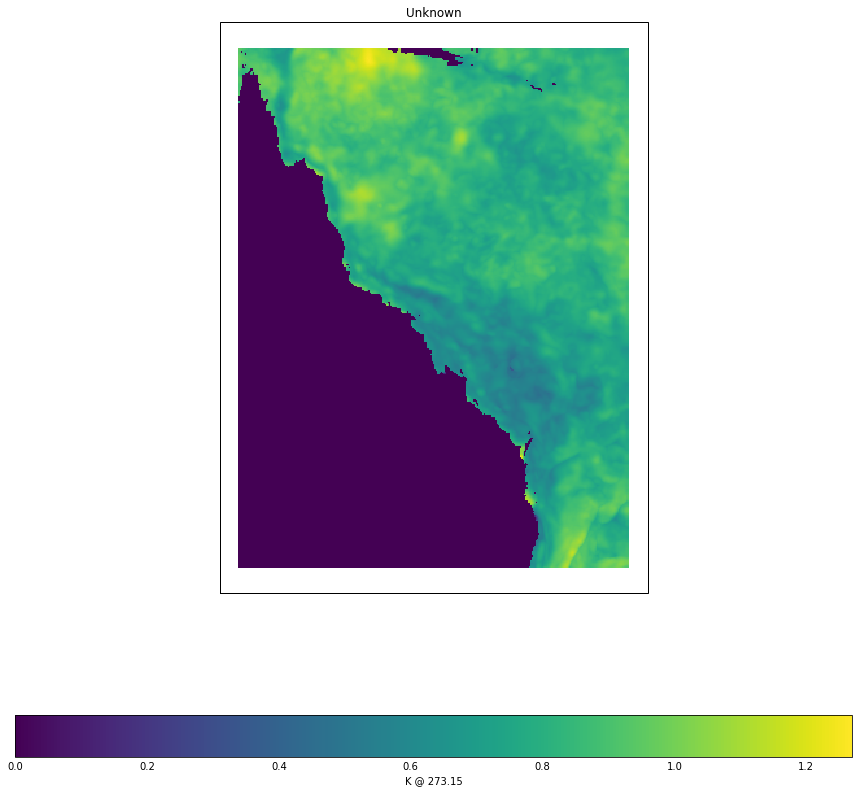

In [31]:
fig = plt.figure(figsize=(15, 15))
dhm_cube_gbr_max = dhm_cube_gbr.collapsed('time',iris.analysis.MAX)
qplt.pcolormesh(dhm_cube_gbr_max)

Text(0.5,0,'year')

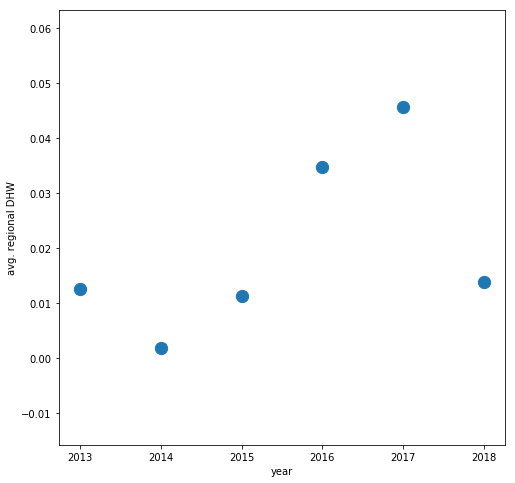

In [38]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(dhw_avg.coord('year').points,dhw_avg.data,s=150)
plt.ylabel('avg. regional DHW')
plt.xlabel('year')